# Aztec G-dDT Test Run

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import os
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "png"

## Perform Simulation

In [2]:
from aztec_gddt.experiment import test_run
from aztec_gddt.scenario_experiments import scenario_group_1_experiment


exp = scenario_group_1_experiment()


from cadCAD.engine import ExecutionContext, ExecutionMode, Executor


_exec_mode = ExecutionMode().single_mode
exec_context = ExecutionContext(_exec_mode, additional_objs={'deepcopy_off': True})
executor = Executor(exec_context=exec_context, configs=exp.configs, supress_print=False)

# Execute the cadCAD experiment
(records, tensor_field, _) = executor.execute()

# Parse the output as a pandas DataFrame
df = pd.DataFrame(records)

# Drop substeps
first_ind = (df.substep == 0) & (df.timestep == 0)
last_ind = df.substep == max(df.substep)
inds_to_drop = first_ind | last_ind
df = df.loc[inds_to_drop].drop(columns=['substep'])


# Assign Params
M_dict = exp.configs[0].sim_config['M']
params_set = set(M_dict.keys())

selected_params = params_set
# Attribute parameters to each row*

from cadCAD.tools.execution.easy_run import select_config_M_dict # type: ignore
params_dict = select_config_M_dict(exp.configs, 0, selected_params)

# Handles all cases of parameter types including list
for key, value in params_dict.items():
    df[key] = df.apply(lambda _: value, axis=1)

for i, (_, n_df) in enumerate(df.groupby(['simulation', 'subset', 'run'])):
    params_dict = select_config_M_dict(exp.configs, i, selected_params)
    for key, value in params_dict.items():
        df.loc[n_df.index, key] = df.loc[n_df.index].apply(
            lambda _: value, axis=1)
        

sim_df = df


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (2, 2000, 84, 30, 32)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 42, 19, 32)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (1000, 42, 11, 32)


Initializing configurations:   0%|          | 0/30 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/180030 [00:00<?, ?it/s]

Total execution time: 9.87s


## Visualization over Model Features

In [3]:
sim_df.head(5)

,timestep,l1_blocks_passed,delta_l1_blocks,l2_blocks_passed,agents,validator_set,current_epoch,last_epoch,last_reward_time_in_l1,last_reward,...,AVERAGE_TX_COUNT_PER_SLOT,PROVING_COST_MODIFICATION_E,FEE_JUICE_PRICE_MODIFICATION_E,ORACLE_UPDATE_FREQUENCY_E,JUICE_PER_WEI_MEAN,JUICE_PER_WEI_STD,JUICE_PER_MANA_MEAN,JUICE_PER_MANA_STD,PROVING_COST_MODIFIER_INITIAL_C,FEE_JUICE_PRICE_MODIFIER_INITIAL_C
0,0,0,0,0,"[Agent(uuid='0', commitment_bond=4.52807762003...",{},"Epoch(init_time_in_l1=-999, validators=[], slo...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,360,0.005,0.001,0.5,5.0,2.0,10.0,10.0,1000,1.0
6,1,1,1,1,"[Agent(uuid='0', commitment_bond=4.52807762003...",{},"Epoch(init_time_in_l1=1, validators=['165', '2...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,360,0.005,0.001,0.5,5.0,2.0,10.0,10.0,1000,1.0
12,2,2,1,1,"[Agent(uuid='0', commitment_bond=4.52807762003...",{},"Epoch(init_time_in_l1=1, validators=['165', '2...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,360,0.005,0.001,0.5,5.0,2.0,10.0,10.0,1000,1.0
18,3,3,1,1,"[Agent(uuid='0', commitment_bond=4.52807762003...",{},"Epoch(init_time_in_l1=1, validators=['165', '2...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,360,0.005,0.001,0.5,5.0,2.0,10.0,10.0,1000,1.0
24,4,4,1,2,"[Agent(uuid='0', commitment_bond=4.52807762003...",{},"Epoch(init_time_in_l1=1, validators=['165', '2...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,360,0.005,0.001,0.5,5.0,2.0,10.0,10.0,1000,1.0


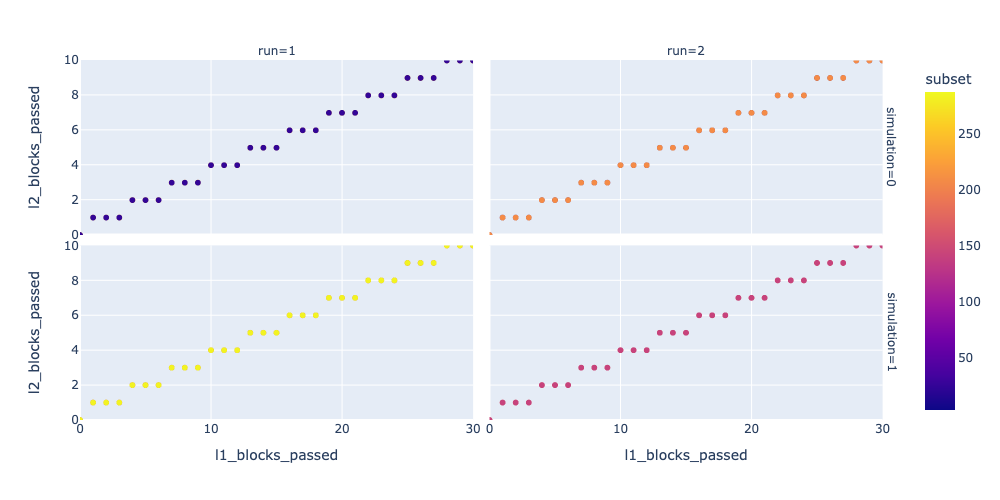

In [4]:
fig = px.scatter(sim_df.reset_index(), x='l1_blocks_passed', y='l2_blocks_passed', color='subset', facet_col='run', facet_row='simulation')
fig.update_layout(yaxis_range=[0, 10], xaxis_range=[0,  10 * 3], width=1000, height=500)
fig.show()

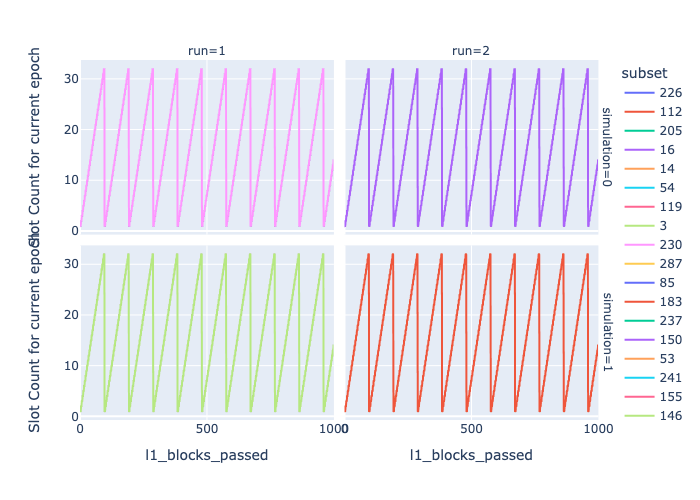

In [5]:
y = sim_df.current_epoch.map(lambda x: len(x.slots))

fig = px.line(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Slot Count for current epoch'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

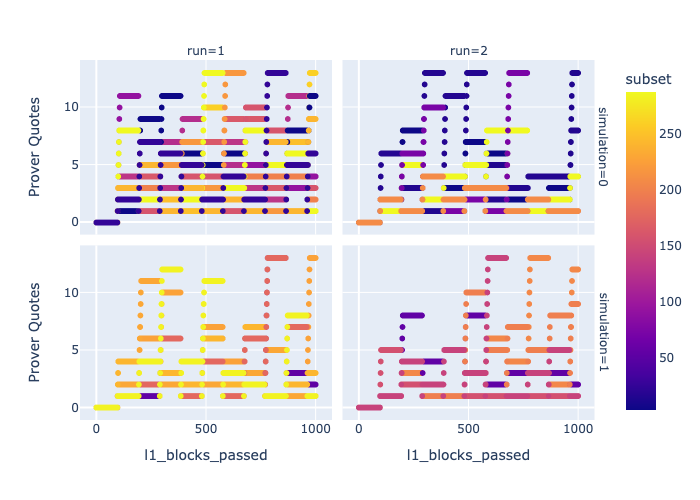

In [6]:
y = sim_df.last_epoch.map(lambda x: len(x.prover_quotes))

fig = px.scatter(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Prover Quotes'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

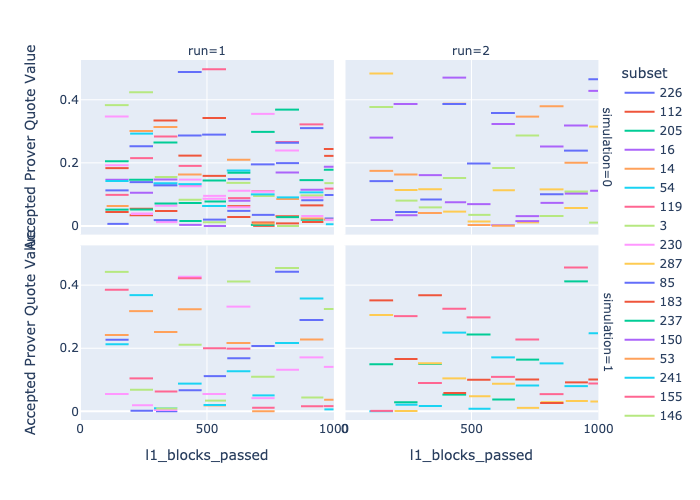

In [7]:
y = sim_df.last_epoch.map(lambda x: x.accepted_prover_quote)

fig = px.line(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Accepted Prover Quote Value'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

## Visualization over PSUU Per-Trajectory Metrics

In [8]:
from aztec_gddt.psuu.metrics import *

In [9]:
for label, fn in PER_TRAJECTORY_METRICS.items():
    print(f"{label}: {fn.__name__}")
    print(sim_df.reset_index().groupby(['simulation', 'subset', 'run']).apply(fn, include_groups=False))
    print("---")

T-M1: relative_volatility_across_time
simulation  subset  run
0           3       2      0.002207
            6       1      0.017291
            14      2      0.033265
            16      2      0.029664
            25      1      0.004844
            71      2      0.006672
            85      1      0.022822
            112     1      0.023444
            119     1      0.010270
            146     1      0.030344
            150     1      0.041636
            183     1      0.025624
            199     1      0.045132
            207     2      0.004173
            220     1      0.026090
            226     1      0.049032
            237     1      0.035743
            262     1      0.022742
            287     2      0.009461
1           53      1      0.023097
            54      2      0.005706
            141     2      0.027977
            155     2      0.023321
            177     1      0.004743
            197     2      0.009937
            205     2      0.010592
  

In [10]:
for label, fn in PER_TRAJECTORY_GROUP_METRICS.items():

    groups = list(sim_df.reset_index().groupby(['simulation']))
    for i, g in groups:
        dfs = [el[1] for el in list(g.groupby('run'))]
        print(f"{label}: {fn.__name__}")
        print(fn(dfs))
        print("---")    

TG-M1: <lambda>
0.008668968670575268
---
TG-M1: <lambda>
0.007393726519066043
---
TG-M2: <lambda>
19.0
---
TG-M2: <lambda>
19.0
---
TG-M3: <lambda>
1.5
---
TG-M3: <lambda>
1.5
---
TG-M4: <lambda>
0.9963742690058479
---
TG-M4: <lambda>
0.9982607607607608
---
TG-M5: <lambda>
nan
---
TG-M5: <lambda>
nan
---
TG-M6: <lambda>
0.0
---
TG-M6: <lambda>
0.0
---
TG-M7: <lambda>
1.0
---
TG-M7: <lambda>
1.0
---
TG-M8: <lambda>
nan
---
TG-M8: <lambda>
nan
---
TG-M9: <lambda>
nan
---
TG-M9: <lambda>
nan
---
TG-M10: <lambda>
nan
---
TG-M10: <lambda>
nan
---
TG-M11: <lambda>
nan
---
TG-M11: <lambda>
nan
---
TG-M12: <lambda>
nan
---
TG-M12: <lambda>
nan
---
TG-M13: <lambda>
nan
---
TG-M13: <lambda>
nan
---


In [11]:
control_params = [
        'RELATIVE_TARGET_MANA_PER_BLOCK',
        'MAXIMUM_MANA_PER_BLOCK',
        'MINIMUM_MULTIPLIER_CONGESTION',
        'UPDATE_FRACTION_CONGESTION',
        'OVERHEAD_MANA_PER_TX',
        'PROVING_COST_MODIFIER_INITIAL_C',
        'FEE_JUICE_PRICE_MODIFIER_INITIAL_C',
        'MAXIMUM_UPDATE_PERCENTAGE_C',
        ]

In [12]:
from aztec_gddt.psuu.metrics import *


for control_param in control_params:
    print(f"### {control_param} ###")
    groups = list(sim_df.reset_index().groupby([control_param]))

    for i, g in groups:
        print(f"{control_param} = {i}")
        for label, fn in PER_TRAJECTORY_GROUP_METRICS.items():
            dfs = [el[1] for el in list(g.groupby(['simulation', 'subset', 'run']))]
            print(f"{label}={fn(dfs) :.3f}")
        print("---")

### RELATIVE_TARGET_MANA_PER_BLOCK ###
RELATIVE_TARGET_MANA_PER_BLOCK = (0.1,)
TG-M1=0.019
TG-M2=28.333
TG-M3=1.750
TG-M4=0.995
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M12=nan
TG-M13=nan
---
RELATIVE_TARGET_MANA_PER_BLOCK = (0.5,)
TG-M1=0.017
TG-M2=13.778
TG-M3=1.333
TG-M4=0.997
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M12=nan
TG-M13=nan
---
RELATIVE_TARGET_MANA_PER_BLOCK = (0.9,)
TG-M1=0.023
TG-M2=14.000
TG-M3=1.333
TG-M4=0.997
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M12=nan
TG-M13=nan
---
### MAXIMUM_MANA_PER_BLOCK ###
MAXIMUM_MANA_PER_BLOCK = (20000000,)
TG-M1=0.016
TG-M2=19.438
TG-M3=1.500
TG-M4=0.996
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M12=nan
TG-M13=nan
---
MAXIMUM_MANA_PER_BLOCK = (40000000,)
TG-M1=0.023
TG-M2=19.929
TG-M3=1.500
TG-M4=0.996
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M12=